# Proyecto 3 de Bases de Datos: Análisis del estado criminal de CR en 2011
Con enfoque al sistema operativo MacOS Sonoma, se tiene que tomar en cuenta cómo se recomienda preparar el proyecto:
```zsh
brew install apache-spark
brew install pyenv
pyenv virtualenv 3.11.1 bd2
pyenv activate bd2
pip3 install jupyter
jupyter notebook
```

## Dependencias

### Descargas

In [1]:
# Dependencias
!pip3 install lxml
!pip3 install xlrd
!pip3 install pandas
!pip3 install pyspark
!pip3 install findspark
!pip3 install matplotlib
!pip3 install seaborn


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


### Importaciones e instanciaciones

In [2]:
# Imports
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SparkSession

from random import choice

# Encontrar Spark
import findspark

import sys

SPARK_PATH = ""
if sys.platform == 'darwin':
    SPARK_PATH = "/opt/homebrew/Cellar/apache-spark/3.5.0/libexec"
elif sys.platform == 'linux':
    SPARK_PATH = "/opt/spark"
elif sys.platform == 'win32':
    SPARK_PATH = "C:/spark" # Verificar la ruta correcta

findspark.init(SPARK_PATH)

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

### Inicialización del SPARK Session

In [3]:
# Conexión con POSTGRESQL
POSTGRESQL_URL = "jdbc:postgresql://localhost/"
POSTGRESQL_USER = "postgres"
POSTGRESQL_PASSWORD = "wikir"

'''
Funcion qie crea una sesion de spark

Parametros:
No tiene

Retorna:
spark: session de spark
'''
def create_spark_session():

    spark = SparkSession \
      .builder \
      .appName("Basic JDBC pipeline") \
      .config("spark.driver.extraClassPath", "postgresql-42.6.0.jar") \
      .config("spark.executor.extraClassPath", "postgresql-42.6.0.jar") \
      .getOrCreate()
    return spark

# La creación en sí del contexto de Spark
spark = create_spark_session()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/17 01:08:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Descarga, manejo y limpieza de datos

### Funciones

In [4]:
'''
Funcion que crea un dataframe a partir de un archivo excel

Parametros:
file_name: nombre del archivo html
skiprows: cantidad de filas a saltar
usecols: columnas a utilizar

Retorna:
df: dataframe creado a partir del archivo excel
'''
def create_df_excel(file_name, skiprows, usecols):
    pd_df = pd.read_excel(file_name, skiprows=skiprows, usecols=usecols)
    df = spark.createDataFrame(pd_df)
    return df

'''
Funcion que crea un dataframe a partir de un archivo html

Parametros:
file_name: nombre del archivo html

Retorna:
df: dataframe creado a partir del archivo html
'''
def create_df_html(file_name):
    pd_df = pd.read_html(file_name)
    df = spark.createDataFrame(pd_df[0])
    return df


In [5]:
'''
Funcion que quita las filas vacias de un dataframe

Parametros:
df: dataframe a limpiar

Retorna:
dataframe sin filas vacias
'''
def quitar_vacios(df):
    return df.dropna()

'''
Funcion que quita los espacios de una columna

Parametros:
dataframe: dataframe a limpiar
nombre_columna: nombre de la columna a limpiar

Retorna:
dataframe con la columna limpia
'''
def limpiar_espacios(dataframe, nombre_columna):
    return dataframe.withColumn(nombre_columna,trim(col(nombre_columna)))

'''
Funcion que cambia los valores de una columna a minuscula

Parametros:
dataframe: dataframe a limpiar
nombre_columna: nombre de la columna a limpiar

Retorna:
dataframe con la columna en minuscula
'''
def minuscula(dataframe,nombre_columna):
    return dataframe.withColumn(nombre_columna,lower(col(nombre_columna)))

In [6]:
'''
Funcion que convierte el tipo de una columna al tipo especificado

Parametros:
dataframe: dataframe a modificar
nombre_columna: nombre de la columna a modificar
tipo: tipo al que se quiere convertir la columna

Retorna:
dataframe con la columna modificada
'''
def convertir_a_tipo(dataframe, nombre_columna, tipo):
    return dataframe.withColumn(nombre_columna, col(nombre_columna).cast(tipo))

In [7]:
'''
Funcion que concatena Provincia + Canton + Distrito en una sola columna

Parametros:
df: Dataframe con las ubicaciones separadas

Retorna:
df: Dataframe con la nueva columna concatenada
'''
def concatenar_ubicacion(df):
    df = df.withColumn("ubi",concat_ws(",", df.Provincia, df.Canton, df.Distrito))\
        .drop("Provincia","Canton","Distrito")
    return df

In [8]:
"""
Agrega una columna de índices a un dataframe que va de 0 a n-1, donde n es la cantidad de filas del dataframe

Parametros:
df: dataframe al que se le quiere agregar el índice

Retorna:
dataframe con la columna de índices agregada
"""
def agregar_indice(df):
    # https://stackoverflow.com/a/48268853/8016766
    new_schema = StructType(
                [StructField("id",LongType(),True)]
                + df.schema.fields
            )
    new_rdd = df.rdd.zipWithIndex().map(lambda args: ([args[1]] + list(args[0])))
    return spark.createDataFrame(new_rdd, new_schema)

"""
Procesa la columna del INEC llamada "Provincia, cantón y distrito" y la convierte en una columna de ubicación agregada

Parametros:
df: dataframe al que se le quiere agregar la columna de ubicación agregada

Retorna:
dataframe con la columna de ubicación agregada agregada
"""
def procesar_columna_ubicacion_agregada(df):
    # País: {Provincia: {Cantón: {Distrito: {}...}...}...}
    # La separación se hace por sumas acumuladas de la columna de población

    # Preparamos la información para el procesamiento de las filas
    cantidad_niveles_para_activar = 4
    # Las pilas ayudan a saber si se debe activar/desactivar un nivel
    pila = [float("inf"), 0, 0]
    pila_ubicacion = []
    
    # La entrada original pero con índice y sin la columna "rara"
    df_alt = agregar_indice(df) \
        .drop("Provincia, cantón y distrito")
    
    """
    Función mágica creada para procesar las filas del dataframe

    Parametros:
    row: fila del dataframe
    idx: índice de la fila

    Retorna:
    True si se debe agregar la fila al nuevo dataframe + la tupla de información procesada, False si no
    """
    def procesar_fila(row, idx):
        poblacion = row[1]
        if poblacion is None:
            return
        pila_ubicacion.append(row[0])
        pila[-2] += poblacion
        pila[-1] = poblacion
        pila.append(0)
        pila.append(0)

        if len(pila_ubicacion) == cantidad_niveles_para_activar:
            # Este código es feo porque ignora el primer elemento de la pila por el formato
            texto = ','.join(pila_ubicacion[1:])

            pila.pop()
            pila.pop()
            pila_ubicacion.pop()
            while pila[-2] >= pila[-3]:
                pila.pop()
                pila.pop()
                pila_ubicacion.pop()
            return True, (idx, texto)
        return False, None

    """
    Función generadora de filas para ayudar con eficiencia

    Parametros:
    df: dataframe a procesar

    Retorna:
    (con yield) fila procesada
    """
    def generador_filas(df):
        for idx, row in enumerate(df.collect()):
            info_fila = procesar_fila(row, idx)
            if info_fila[0]:
                yield info_fila[1]

    entry_data = (i for i in generador_filas(df))
    
    new_one = spark.createDataFrame(entry_data, StructType([StructField("id",LongType(),True),StructField("ubi",StringType(),True)]))

    # Unimos el dataframe "original" con el nuevo que ya procesó las ubicaciones
    return df_alt.join(new_one, df_alt.id == new_one.id).drop("id")

In [9]:
'''
Funcion que hace un left join entre dos dataframes
para encontrar las ubicaciones que no estan en el en el lado derecho.

Parametros:
df_left: Dataframe que contiene las ubicaciones que se quieren buscar
df_right: Dataframe derecho 

Retorna:
Dataframe con las ubicaciones que no estan en el lado derecho
'''
def ubicaciones_no_encontradas(df_left, df_right):
    df_left = df_left.select("ubi").distinct()
    df_right = df_right.select("ubi").distinct()
    df_left.createOrReplaceTempView("a")
    df_right.createOrReplaceTempView("b")
    df = spark.sql("SELECT a.ubi FROM a LEFT JOIN b ON a.ubi = b.ubi WHERE b.ubi IS NULL")
    return df


In [10]:
'''
Funcion que cuenta las ubicaciones que no estan en el df_right

Parametros:
df_left: Dataframe que contiene las ubicaciones que se quieren buscar
df_right: Dataframe derecho

Retorna:
Cantidad de ubicaciones que no estan en el df_right
'''
def contar_ubicaciones_no_encontradas(df_left, df_right):
    df = ubicaciones_no_encontradas(df_left, df_right)
    return df.count()

In [11]:

'''
Funcion que quita las tildes y la ñ de una columna

Parametros:
dataframe: dataframe a limpiar
columna: nombre de la columna a limpiar

Retorna:
dataframe con la columna limpia
'''
def quitar_tildes_y_enie(dataframe, columna):
    def quitar_tildes_eñes(columna):
        return translate(columna, "áéíóúüñ", "aeiouun")

    return dataframe.withColumn(columna,quitar_tildes_eñes(col(columna)))

### Cargar los archivos del OIJ y del INEC

In [12]:
# Procesar OIJ

# Leer los datos
df_oij = create_df_html('OIJ.ods')
df_oij.show(truncate=False)

# Limpiar los datos
df_oij = limpiar_espacios(df_oij,"Provincia")
df_oij = limpiar_espacios(df_oij,"Canton")
df_oij = limpiar_espacios(df_oij,"Distrito")
df_oij = limpiar_espacios(df_oij, "Fecha")
df_oij = convertir_a_tipo(df_oij,"Fecha",DateType())
df_oij = concatenar_ubicacion(df_oij)
df_oij = minuscula(df_oij,"ubi")

df_oij.show(truncate=False)


/Users/maxlatysh/.pyenv/versions/3.11.1/envs/bd2/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+------+-----------+----------+-------------------+-----------+---------------------------------+-------------+------+------------+----------+------------+-------------+
|Delito|SubDelito  |Fecha     |Hora               |Victima    |SubVictima                       |Edad         |Genero|Nacionalidad|Provincia |Canton      |Distrito     |
+------+-----------+----------+-------------------+-----------+---------------------------------+-------------+------+------------+----------+------------+-------------+
|ASALTO|ARMA BLANCA|2011-01-28|15:00:00 - 17:59:59|PERSONA    |MENOR DE EDAD [PERSONA]          |Menor de edad|HOMBRE|COSTA RICA  |PUNTARENAS|BUENOS AIRES|BUENOS AIRES |
|ASALTO|ARMA BLANCA|2011-02-08|18:00:00 - 20:59:59|PERSONA    |CLIENTE LOCAL COMERCIAL [PERSONA]|Mayor de edad|HOMBRE|COSTA RICA  |HEREDIA   |HEREDIA     |SAN FRANCISCO|
|ASALTO|ARMA BLANCA|2011-07-02|18:00:00 - 20:59:59|EDIFICACION|TIENDA/BOUTIQUE [EDIFICACION]    |Mayor de edad|MUJER |COSTA RICA  |ALAJUELA  |SAN CARL

In [13]:
# Procesar INEC

# Leer los datos
df_inec = create_df_excel('INEC.xls', [0, 1, 2, 3, 4], [i for i in range(1, 8)])
df_inec.show(truncate=False)

# Limpiar los datos
df_inec = quitar_vacios(df_inec)
df_inec = limpiar_espacios(df_inec, "Provincia, cantón y distrito")
df_inec = limpiar_espacios(df_inec, "Tasa de desempleo abierto")
df_inec = convertir_a_tipo(df_inec, "Tasa de desempleo abierto", DoubleType())
df_inec = convertir_a_tipo(df_inec, "Población de 15 años y más", IntegerType())
df_inec = minuscula(df_inec,"Provincia, cantón y distrito")

# Procesamiento mágico de la columna de ubicación
df_inec = procesar_columna_ubicacion_agregada(df_inec)

df_inec.sort(asc("ubi")).show(truncate=False)

+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+
|Provincia, cantón y distrito|Población de 15 años y más|Tasa neta de participación|Tasa de ocupación |Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|
+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+
|NaN                         |NaN                       |NaN                       |NaN               |NaN                      |NaN                                            |NaN                              |
|NaN                         |NaN                       |NaN                       |NaN               |NaN                      |NaN                    

/Users/maxlatysh/.pyenv/versions/3.11.1/envs/bd2/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+------------------------------+
|Población de 15 años y más|Tasa neta de participación|Tasa de ocupación |Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|ubi                           |
+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+------------------------------+
|34485                     |55.08481948673336         |53.376830506017114|3.1006527690040007       |44.91518051326664                              |1.2623183828174354               |alajuela,alajuela,alajuela    |
|5077                      |57.041559976364           |54.89462280874532 |3.7638121546961325       |42.95844002363601                           

### Probar y corregir las ubicaciones diferentes

In [14]:
# Comparar OIJ con INEC

df_comp = ubicaciones_no_encontradas(df_oij, df_inec)
df_comp.sort(asc("ubi")).show(truncate=False)
print("Cantidad de ubicaciones no encontradas: " + str(contar_ubicaciones_no_encontradas(df_oij, df_inec)))

+-------------------------------+
|ubi                            |
+-------------------------------+
|alajuela,alajuela,guacima      |
|alajuela,alajuela,la garita    |
|alajuela,alajuela,rio segundo  |
|alajuela,alajuela,san jose     |
|alajuela,alajuela,turrucares   |
|alajuela,atenas,concepcion     |
|alajuela,atenas,jesus          |
|alajuela,atenas,san jose       |
|alajuela,grecia,bolivar        |
|alajuela,grecia,desconocido    |
|alajuela,grecia,rio cuarto     |
|alajuela,grecia,san jose       |
|alajuela,guatuso,desconocido   |
|alajuela,los chiles,cano negro |
|alajuela,los chiles,desconocido|
|alajuela,naranjo,cirri sur     |
|alajuela,naranjo,desconocido   |
|alajuela,naranjo,rosario       |
|alajuela,naranjo,san jeronimo  |
|alajuela,naranjo,san jose      |
+-------------------------------+
only showing top 20 rows

Cantidad de ubicaciones no encontradas: 318


In [15]:
# Eliminar tildes y ñ de OIJ e INEC
df_oij = quitar_tildes_y_enie(df_oij, "ubi")
df_inec = quitar_tildes_y_enie(df_inec, "ubi")

In [16]:
# Comparar OIJ con INEC otra vez
df_comp = ubicaciones_no_encontradas(df_oij, df_inec)
df_comp.sort(asc("ubi")).show(truncate=False)
print("Cantidad de ubicaciones no encontradas: " + str(contar_ubicaciones_no_encontradas(df_oij, df_inec)))

+-------------------------------+
|ubi                            |
+-------------------------------+
|alajuela,alajuela,la garita    |
|alajuela,grecia,desconocido    |
|alajuela,guatuso,desconocido   |
|alajuela,los chiles,desconocido|
|alajuela,naranjo,desconocido   |
|alajuela,naranjo,rosario       |
|alajuela,orotina,ceiba         |
|alajuela,orotina,desconocido   |
|alajuela,orotina,mastate       |
|alajuela,palmares,granja       |
|alajuela,san carlos,fortuna    |
|alajuela,san carlos,palmera    |
|alajuela,san carlos,tigra      |
|alajuela,san mateo,desconocido |
|alajuela,san ramon,desconocido |
|alajuela,sarchi,rodriguez      |
|alajuela,sarchi,san pedro      |
|alajuela,sarchi,sarchi norte   |
|alajuela,sarchi,sarchi sur     |
|alajuela,sarchi,toro amarillo  |
+-------------------------------+
only showing top 20 rows

Cantidad de ubicaciones no encontradas: 90


## Guardar Dataframes del INEC y OIJ en la base de datos de POSTGRESQL

### Función

In [17]:
'''
Funcion que guarda un dataframe en PostgreSQL

Parametros:
df: dataframe a guardar
nombre_tabla: nombre de la tabla en la que se guardara el dataframe

Retorna:
No tiene
'''
def guardar_tabla_postgresql(df, nombre_tabla):
    df.select("*")\
        .write.mode("overwrite") \
        .format("jdbc") \
        .option("url", POSTGRESQL_URL) \
        .option("driver", "org.postgresql.Driver") \
        .option("dbtable", nombre_tabla) \
        .option("user", POSTGRESQL_USER) \
        .option("password", POSTGRESQL_PASSWORD).save()

### Ejecutar procedimientos

In [18]:
# Guardar OIJ e INEC en PostgreSQL
guardar_tabla_postgresql(df_oij, "oij")
guardar_tabla_postgresql(df_inec, "inec")

## Visualizaciones

### Creación del JOIN principal

In [19]:
# Crear join entre OIJ e INEC
df_join = df_inec.join(df_oij, df_inec.ubi == df_oij.ubi).drop(df_oij.ubi)

### Visualización 1
La cantidad de delitos y la tasa de ocupación para los 10 distritos con más delitos en el país.

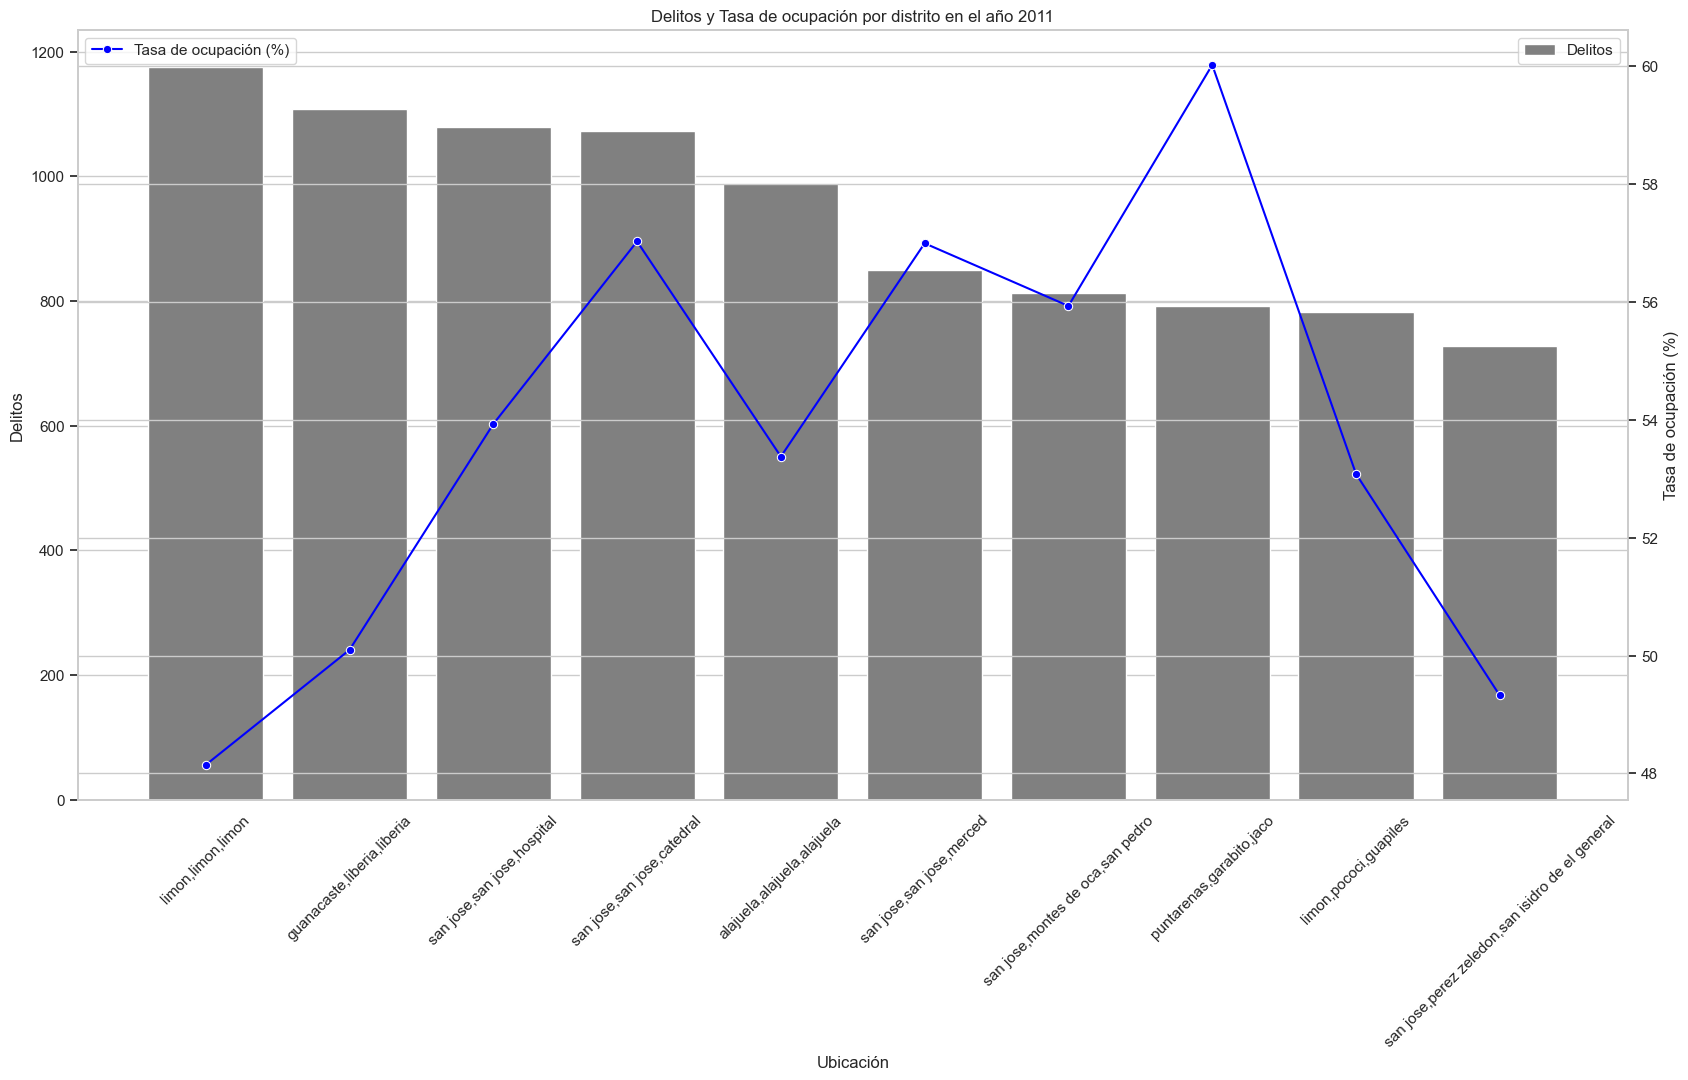

In [20]:
# Preparación de la información para el análisis
top10 = df_join.groupBy("ubi").agg(count("Delito").alias("Delitos"), avg("Tasa de ocupación").alias("TasaOcupacion")).orderBy(desc("Delitos")).limit(10)
top10_pd = top10.toPandas()

# Preparación del plot
sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.figure(figsize=(20, 10))

# Histograma de delitos por ubicación
temp_plot = sns.barplot(x="ubi", y="Delitos", data=top10_pd, color="grey", label="Delitos")
# Manipulación de labels
plt.xticks(rotation=45)
plt.xlabel("Ubicación")

# Tasa de ocupación por ubicación
ax2 = plt.twinx()
temp_plot = sns.lineplot(x="ubi", y="TasaOcupacion", data=top10_pd, color="blue", marker="o", ax=ax2, label="Tasa de ocupación (%)")

# Despliege del plot
plt.legend(loc="upper left")
plt.ylabel("Delitos")
ax2.set_ylabel("Tasa de ocupación (%)")
plt.title("Delitos y Tasa de ocupación por distrito en el año 2011")
plt.show()

### Visualización 2
Grafique la cantidad de delitos por día de la semana para el distrito con más delitos.

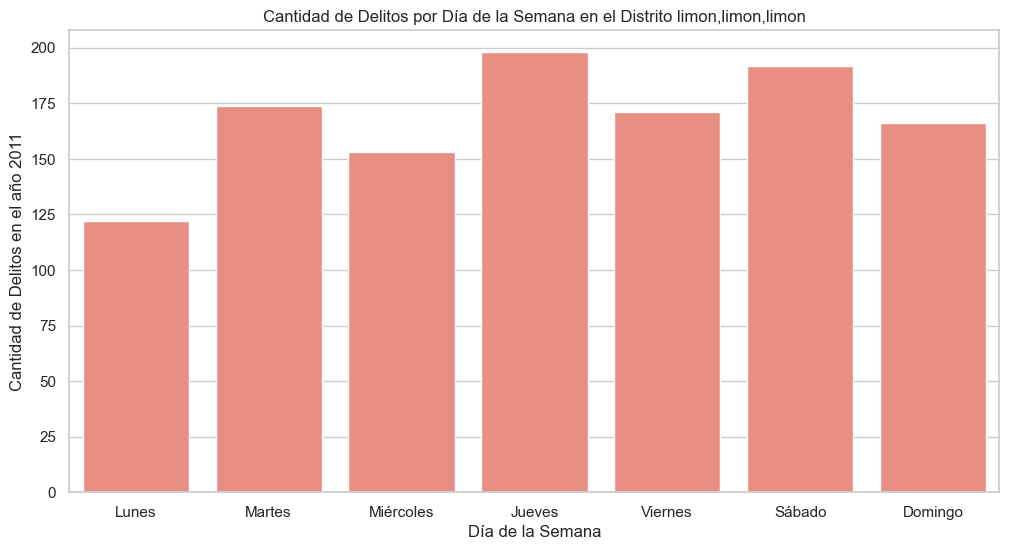

In [21]:
# Filtrar el DataFrame para obtener los datos del distrito con más delitos
distrito_mas_delitos = df_join.groupBy("ubi").agg(count("Delito").alias("Delitos")).orderBy(desc("Delitos")).limit(1).collect()[0][0]
df_distrito_mas_delitos = df_join.filter(col("ubi") == distrito_mas_delitos)

# Extraer el día de la semana y contar la cantidad de delitos por día
delitos_por_dia = df_distrito_mas_delitos.withColumn("DiaSemana", dayofweek(col("Fecha")))
delitos_por_dia_count = delitos_por_dia.groupBy("DiaSemana").count().orderBy("DiaSemana")
dias_semana = {
    1: "Lunes",
    2: "Martes",
    3: "Miércoles",
    4: "Jueves",
    5: "Viernes",
    6: "Sábado",
    7: "Domingo"
}

# Convertir el resultado a Pandas para la visualización con Seaborn
delitos_por_dia_count_pd = delitos_por_dia_count.toPandas()

# Mapear los días de la semana a su nombre
delitos_por_dia_count_pd["DiaSemana"] = delitos_por_dia_count_pd["DiaSemana"].map(dias_semana)

# Configurar el estilo y tamaño del plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de barras
sns.barplot(x="DiaSemana", y="count", data=delitos_por_dia_count_pd, color="salmon")

# Manipulación de etiquetas y título
plt.xlabel("Día de la Semana")
plt.ylabel("Cantidad de Delitos en el año 2011")
plt.title(f"Cantidad de Delitos por Día de la Semana en el Distrito {distrito_mas_delitos}")

# Mostrar el plot
plt.show()

### Visualización 3
Grafique la cantidad de delitos por tipo y por distrito. Es decir, para el distrito seleccionado se debe graficar la cantidad de delitos por tipo. 

In [22]:
# Obtener la lista de distritos y ordenarla
distritos_lista = df_join.select("ubi").distinct().rdd.flatMap(lambda x: x).collect()
distritos_lista.sort()

# Seleccionar el primer distrito de la lista como valor predeterminado
distrito_mas_delitos = choice(distritos_lista)

# Crear el widget de menú desplegable
distrito_selector = widgets.Dropdown(
    options=distritos_lista,
    value=distrito_mas_delitos,
    description='Seleccionar Distrito:',
    disabled=False,
)

# Función para actualizar el gráfico cuando se cambia el distrito seleccionado
def update_grafico(distrito_seleccionado):

    # Filtrar el DataFrame para obtener los datos del distrito seleccionado
    delitos_por_tipo = df_join.filter(df_join.ubi == distrito_seleccionado).groupBy("Delito").count().orderBy(desc("count"))
    
    # Convertir el resultado a Pandas para la visualización con Seaborn
    delitos_por_tipo_pd = delitos_por_tipo.toPandas()

    # Configurar el estilo y tamaño del plot
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    sns.set_palette("pastel")

    # Crear el gráfico de barras
    sns.barplot(x="count", y="Delito", data=delitos_por_tipo_pd, color="navy")

    # Manipulación de etiquetas y título
    plt.ylabel("Tipo de Delito")
    plt.xlabel("Cantidad de Delitos")
    plt.title(f"Cantidad de Delitos por Tipo en el Distrito {distrito_seleccionado}")

    # Mostrar el plot
    plt.show()

# Mostrar el widget y el gráfico
output = widgets.interactive(update_grafico, distrito_seleccionado=distrito_selector)
display(output)

interactive(children=(Dropdown(description='Seleccionar Distrito:', index=274, options=('alajuela,alajuela,ala…

### Visualización 4
Grafique la cantidad de delitos por sexo para todo el conjunto de datos.

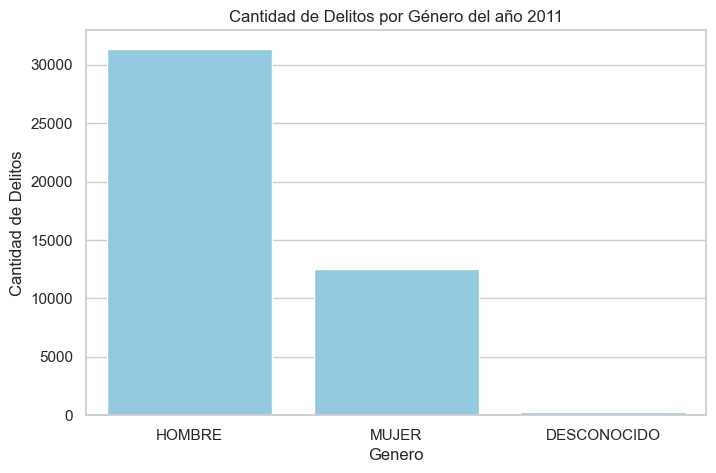

In [23]:
# Filtrar el DataFrame para obtener los datos de delitos por sexo
delitos_por_sexo = df_join.groupBy("Genero").agg(count("*").alias("Cantidad_De_Delitos")).orderBy(desc("Cantidad_De_Delitos"))

# Convertir el resultado a Pandas para la visualización con Seaborn
delitos_por_sexo_pd = delitos_por_sexo.toPandas()

# Configurar el estilo y tamaño del plot
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de barras
sns.barplot(x="Genero", y="Cantidad_De_Delitos", data=delitos_por_sexo_pd, color="skyblue")

# Manipulación de etiquetas y título
plt.xlabel("Genero")
plt.ylabel("Cantidad de Delitos")
plt.title("Cantidad de Delitos por Género del año 2011")

# Mostrar el plot
plt.show()


### Visualización 5
Grafique la cantidad de delitos por las 10 nacionalidades mas peligrosas.

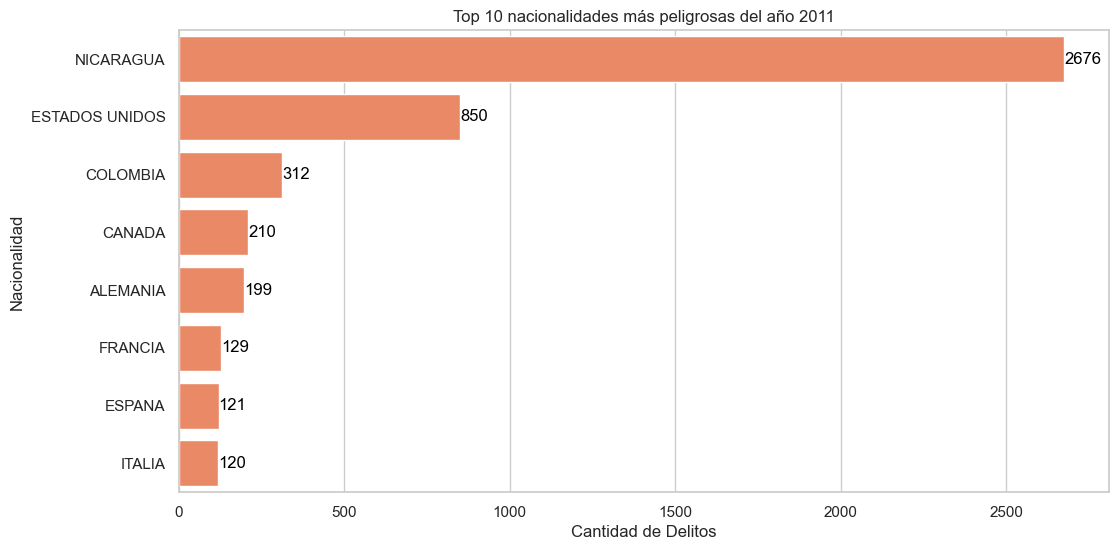

In [24]:
# Filtrar el DataFrame para obtener los datos de delitos por nacionalidad
delitos_top_10_nacionalidades = df_join.groupBy("Nacionalidad").agg(count("*").alias("Cantidad_De_Delitos")).orderBy(desc("Cantidad_De_Delitos")).limit(10)
df_arr = delitos_top_10_nacionalidades.filter((delitos_top_10_nacionalidades.Nacionalidad != "COSTA RICA") & (delitos_top_10_nacionalidades.Nacionalidad != "Desconocido"))

# Convertir el resultado a Pandas para la visualización con Seaborn
df_arr = df_arr.toPandas()

# Configurar el estilo y tamaño del plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de barras con x e y intercambiados
bar_plot = sns.barplot(x="Cantidad_De_Delitos", y="Nacionalidad", data=df_arr, color="coral")

# Agregar las cifras exactas al lado de cada barra
for index, value in enumerate(df_arr["Cantidad_De_Delitos"]):
    bar_plot.text(value, index, str(value), color='black', ha="left", va="center")

# Manipulación de etiquetas y título
plt.xlabel("Cantidad de Delitos")
plt.ylabel("Nacionalidad")

# Rotar las etiquetas del eje y
plt.yticks(rotation=0)

plt.title("Top 10 nacionalidades más peligrosas del año 2011")

# Mostrar el plot
plt.show()


## Acabar el SPARK Session

In [25]:
spark.stop()

## Referencias
[1] Instituto Nacional de Estadísticas y Censos (2011). Censo 2011: Indicadores económicos, según provincia, cantón y distrito. Recuperado de
https://admin.inec.cr/sites/default/files/media/reempleocenso2011-22.xls_2.xls

[2] Organismo de Investigación Judicial (2018). Estadísticas policiales. Recuperado de https://sitiooij.poder-judicial.go.cr/index.php/apertura/transparencia/estadisticas-policiales

[3] Suhong, K., Param, J., Parminder, K. y Pooya, T. (2018). Crime Analysis Through Machine
Learning. IEEE 9th Annual Information Technology, Electronics and Mobile Communication

[4] Conference (IEMCON). 10.1109/IEMCON.2018.8614828. Recuperado de
https://www.researchgate.net/publication/330475412

[5] freeCodeCamp.org. (2021). PySpark Tutorial [Video]. YouTube. https://www.youtube.com/watch?v=_C8kWso4ne4

[6] GK Codelabs. (2019). Data Visualization with Spark Dataframes & Python Matplotlib | From Scratch [Video]. YouTube. https://www.youtube.com/watch?v=lZvs-YNk4V0